In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing libraries pandas and numpy. Importing historical_data.csv and displaying the column data.


In [6]:
import pandas as pd
import numpy as np
historical_data='/content/drive/MyDrive/historical_data.csv'

trades = pd.read_csv(historical_data)
trades.head()



,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Check for missing values

In [8]:
print("\nMissing Values:")
print(trades.isnull().sum())


Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


Importing fear_greed_index.csv

In [7]:
Fear_greed = '/content/drive/MyDrive/fear_greed_index.csv'
sentiment=pd.read_csv(Fear_greed)
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Checking for missing values

In [9]:
print("\nMissing Values:")
print(sentiment.isnull().sum())


Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64


.shape was used to check number of rows and columns .Check for data cleanliness to verify whether there is missing or duplicate values.

In [10]:
print(trades.shape, sentiment.shape)
print(trades.isna().sum())
print(trades.duplicated().sum())


(211224, 16) (2644, 4)
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
0


Convert timestamp to readable data

In [11]:
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date


Aggregates trade-level data into daily trader metrics.

In [12]:
daily = trades.groupby(["date", "Account"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    trades_count=("Trade ID", "count"),
    avg_trade_size=("Size USD", "mean"),
    avg_position=("Start Position", "mean"),
    long_trades=("Direction", lambda x: (x == "Long").sum()),
    short_trades=("Direction", lambda x: (x == "Short").sum())
).reset_index()

#Calculates directional bias per trader per day.
daily["long_short_ratio"] = (
    daily["long_trades"] / daily["short_trades"].replace(0, np.nan)
)


Combines trader metrics with sentiment.

In [13]:
merged = daily.merge(
    sentiment[["date", "classification", "value"]],
    on="date",
    how="inner"
)


Checks whether performance differs between Fear and Greed


(x > 0).mean()
→ % of profitable days (win rate)

In [14]:
summary = merged.groupby("classification").agg(
    avg_pnl=("daily_pnl", "mean"),
    median_pnl=("daily_pnl", "median"),
    win_rate=("daily_pnl", lambda x: (x > 0).mean()),
    avg_trades=("trades_count", "mean"),
    avg_position=("avg_position", "mean")
)

summary


,avg_pnl,median_pnl,win_rate,avg_trades,avg_position
classification,,,,,
Extreme Greed,35393.098355,0.000000,0.40000,1392.40000,109102.060674
Fear,209372.662205,81389.682515,0.93750,4183.46875,14001.822141
Greed,99675.516731,35988.376437,0.84375,1134.03125,19910.937007
Neutral,19842.797260,-0.418640,0.50000,892.62500,42099.597407


A boxplot comparing PnL distributions.

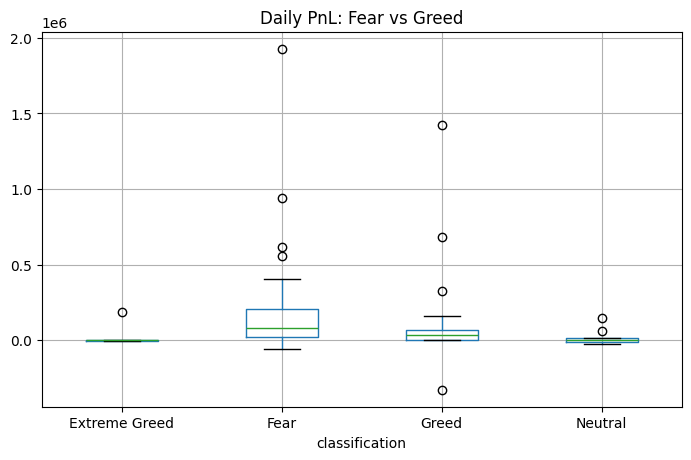

In [15]:
import matplotlib.pyplot as plt

merged.boxplot(
    column="daily_pnl",
    by="classification",
    figsize=(8,5)
)
plt.title("Daily PnL: Fear vs Greed")
plt.suptitle("")
plt.show()
